# sPOD-NN for synthetic data

In [1]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from synthetic_sup import synthetic_sup
import numpy as np

## Data generation / sPOD of the data

#############################################
Synthetic data checks....
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Check 1...
Transformation interpolation error =  3.2648e-05 


/Users/shubhadityaburela/Python/sPOD-NN/tests/../sPOD/lib/sPOD_tools.py:598: UserWarning: Using rSVD to accelarate decomposition procedure may lead to different results, pls check!
  warn("Using rSVD to accelarate decomposition procedure may lead to different results, pls check!")
/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/sklearn/utils/extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


it=1 rel_err= 4.9e-01 norm(dres) = 4.8e-05 norm(Q-Qtilde)/norm(q) =4.9e-01 norm(E)/norm(q) = 0.0e+00 tcpu = 0.41, ranks_frame =  1 1
it=2 rel_err= 1.6e-01 norm(dres) = 3.2e-05 norm(Q-Qtilde)/norm(q) =1.6e-01 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  2 2
it=3 rel_err= 8.4e-02 norm(dres) = 7.7e-06 norm(Q-Qtilde)/norm(q) =8.4e-02 norm(E)/norm(q) = 0.0e+00 tcpu = 0.30, ranks_frame =  2 2
it=4 rel_err= 8.0e-02 norm(dres) = 4.2e-07 norm(Q-Qtilde)/norm(q) =8.0e-02 norm(E)/norm(q) = 0.0e+00 tcpu = 0.29, ranks_frame =  2 2
it=5 rel_err= 7.9e-02 norm(dres) = 7.0e-08 norm(Q-Qtilde)/norm(q) =7.9e-02 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  2 2
it=6 rel_err= 4.2e-02 norm(dres) = 3.7e-06 norm(Q-Qtilde)/norm(q) =4.2e-02 norm(E)/norm(q) = 0.0e+00 tcpu = 0.27, ranks_frame =  3 3
it=7 rel_err= 2.9e-02 norm(dres) = 1.3e-06 norm(Q-Qtilde)/norm(q) =2.9e-02 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  3 3
it=8 rel_err= 2.8e-02 norm(dres) = 1.1e-07 norm(Q-Qtilde)/norm(q) =2.

it=63 rel_err= 5.2e-03 norm(dres) = 2.4e-09 norm(Q-Qtilde)/norm(q) =5.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.74, ranks_frame =  5 5
it=64 rel_err= 5.2e-03 norm(dres) = 2.2e-09 norm(Q-Qtilde)/norm(q) =5.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.86, ranks_frame =  5 5
it=65 rel_err= 5.2e-03 norm(dres) = 2.0e-09 norm(Q-Qtilde)/norm(q) =5.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.37, ranks_frame =  5 5
it=66 rel_err= 5.2e-03 norm(dres) = 1.9e-09 norm(Q-Qtilde)/norm(q) =5.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.29, ranks_frame =  5 5
it=67 rel_err= 5.1e-03 norm(dres) = 1.7e-09 norm(Q-Qtilde)/norm(q) =5.1e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.28, ranks_frame =  5 5
it=68 rel_err= 5.1e-03 norm(dres) = 1.6e-09 norm(Q-Qtilde)/norm(q) =5.1e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.28, ranks_frame =  5 5
it=69 rel_err= 5.1e-03 norm(dres) = 1.5e-09 norm(Q-Qtilde)/norm(q) =5.1e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.29, ranks_frame =  5 5
it=70 rel_err= 5.1e-03 norm(dres) = 1.4e-09 norm(Q-Qtilde)/nor

it=124 rel_err= 3.3e-03 norm(dres) = 1.9e-09 norm(Q-Qtilde)/norm(q) =3.3e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  6 6
it=125 rel_err= 3.3e-03 norm(dres) = 1.7e-09 norm(Q-Qtilde)/norm(q) =3.3e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.38, ranks_frame =  6 6
it=126 rel_err= 3.3e-03 norm(dres) = 1.6e-09 norm(Q-Qtilde)/norm(q) =3.3e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  6 6
it=127 rel_err= 3.2e-03 norm(dres) = 1.5e-09 norm(Q-Qtilde)/norm(q) =3.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  6 6
it=128 rel_err= 3.2e-03 norm(dres) = 1.3e-09 norm(Q-Qtilde)/norm(q) =3.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.34, ranks_frame =  6 6
it=129 rel_err= 3.2e-03 norm(dres) = 1.2e-09 norm(Q-Qtilde)/norm(q) =3.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.30, ranks_frame =  6 6
it=130 rel_err= 3.2e-03 norm(dres) = 1.0e-09 norm(Q-Qtilde)/norm(q) =3.2e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.30, ranks_frame =  6 6
it=131 rel_err= 3.2e-03 norm(dres) = 9.2e-10 norm(Q-Qti

it=185 rel_err= 1.6e-03 norm(dres) = 4.4e-09 norm(Q-Qtilde)/norm(q) =1.6e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  8 8
it=186 rel_err= 1.6e-03 norm(dres) = 1.6e-09 norm(Q-Qtilde)/norm(q) =1.6e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.35, ranks_frame =  8 8
it=187 rel_err= 1.6e-03 norm(dres) = 1.8e-09 norm(Q-Qtilde)/norm(q) =1.6e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  8 8
it=188 rel_err= 1.6e-03 norm(dres) = 1.6e-09 norm(Q-Qtilde)/norm(q) =1.6e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  8 8
it=189 rel_err= 1.5e-03 norm(dres) = 1.3e-09 norm(Q-Qtilde)/norm(q) =1.5e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.41, ranks_frame =  8 8
it=190 rel_err= 1.5e-03 norm(dres) = 1.3e-09 norm(Q-Qtilde)/norm(q) =1.5e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.30, ranks_frame =  8 8
it=191 rel_err= 1.5e-03 norm(dres) = 1.2e-09 norm(Q-Qtilde)/norm(q) =1.5e-03 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  8 8
it=192 rel_err= 1.5e-03 norm(dres) = 1.2e-09 norm(Q-Qti

it=246 rel_err= 9.8e-04 norm(dres) = 6.9e-10 norm(Q-Qtilde)/norm(q) =9.8e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.31, ranks_frame =  8 8
it=247 rel_err= 9.7e-04 norm(dres) = 6.8e-10 norm(Q-Qtilde)/norm(q) =9.7e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.30, ranks_frame =  8 8
it=248 rel_err= 9.6e-04 norm(dres) = 6.7e-10 norm(Q-Qtilde)/norm(q) =9.6e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.33, ranks_frame =  8 8
it=249 rel_err= 9.6e-04 norm(dres) = 6.5e-10 norm(Q-Qtilde)/norm(q) =9.6e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.34, ranks_frame =  8 8
it=250 rel_err= 9.5e-04 norm(dres) = 6.4e-10 norm(Q-Qtilde)/norm(q) =9.5e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.33, ranks_frame =  8 8
it=251 rel_err= 9.4e-04 norm(dres) = 6.3e-10 norm(Q-Qtilde)/norm(q) =9.4e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.38, ranks_frame =  8 8
it=252 rel_err= 9.4e-04 norm(dres) = 6.2e-10 norm(Q-Qtilde)/norm(q) =9.4e-04 norm(E)/norm(q) = 0.0e+00 tcpu = 0.32, ranks_frame =  8 8
it=253 rel_err= 9.3e-04 norm(dres) = 6.1e-10 norm(Q-Qti

/Users/shubhadityaburela/Python/sPOD-NN/tests/../sPOD/lib/sPOD_tools.py:693: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ReturnValue(qtilde_frames, qtilde, rel_err_list, E, ranks, np.asarray(ranks_hist))


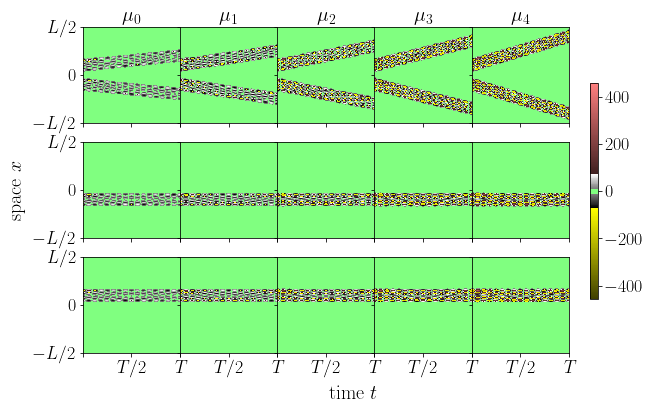

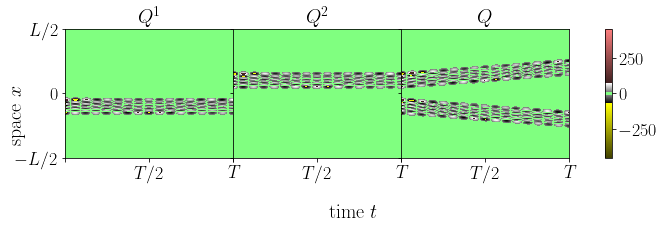

In [3]:
df = synthetic_sup(spod_iter=300, plot_offline_data=True)

## Input data for sPOD-NN 

In [4]:
# We collect the time amplitudes, shifts and the parameters for the training as well as the testing data.
TA_TRAIN = df.TA_TRAIN
SHIFTS_TRAIN = df.SHIFTS_TRAIN
PARAMS_TRAIN = df.PARAMS_TRAIN
TA_TEST = df.TA_TEST
SHIFTS_TEST = df.SHIFTS_TEST
PARAMS_TEST = df.PARAMS_TEST
TA_POD_TRAIN = df.TA_POD_TRAIN
TA_POD_TEST = df.TA_POD_TEST

## ---------------------------------------------------

In [5]:
# ###################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper

# import matplotlib.pyplot as plt
# import os
# from sklearn.utils.extmath import randomized_svd
# from Helper import *
# ############################################

# frame_wise_sPOD = [1, 1]
# time_amplitudes_1 = TA_TRAIN[:df.nmodes, :]
# time_amplitudes_2 = TA_TRAIN[df.nmodes:, :]
# frame_amplitudes_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :]
# ]
# TA_TRAIN = np.concatenate(frame_amplitudes_training, axis=0)

# df.U_list[0] = df.U_list[0][:, :frame_wise_sPOD[0]]
# df.U_list[1] = df.U_list[1][:, :frame_wise_sPOD[1]]
# spodModes = frame_wise_sPOD

# time_amplitudes_1_test = df.U_list[0].transpose() @ df.q1_test
# time_amplitudes_2_test = df.U_list[1].transpose() @ df.q2_test
# amplitudes_test = np.concatenate((time_amplitudes_1_test, time_amplitudes_2_test), axis=0)
# df.TA_TEST = amplitudes_test
# TA_TEST = df.TA_TEST

# ############################################   

# frame_amplitudes_list_interp = []
# for frame in range(2):
#     Nmodes = spodModes[frame]
#     VT = frame_amplitudes_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# df.TA_list_interp = frame_amplitudes_list_interp      
# ############################################    

# frame_wise_POD = sum(frame_wise_sPOD) + 2
# df.U_POD_TRAIN = df.U_POD_TRAIN[:, :frame_wise_POD]
# df.TA_POD_TRAIN = df.TA_POD_TRAIN[:frame_wise_POD, :]
# TA_POD_TRAIN = df.TA_POD_TRAIN

# df.TA_POD_TEST = df.U_POD_TRAIN.transpose() @ df.q_test
# TA_POD_TEST = df.TA_POD_TEST
# ############################################

# data_shape = [len(df.x), 1, 1, 5*len(df.t)]
# dx = df.x[1] - df.x[0]
# L = [df.x[-1]]

# q_train = [df.U_list[0] @ frame_amplitudes_training[0], 
#           df.U_list[1] @ frame_amplitudes_training[1]]

# trafos = df.trafos_train

# NumFrames = 2
# q_sPOD = 0
# for frame in range(NumFrames):
#     q_sPOD += trafos[frame].apply(q_train[frame])
# ############################################
# q_POD = df.U_POD_TRAIN @ df.TA_POD_TRAIN
# ############################################
# q_original = df.q_train[0:len(df.x), :]
# ############################################

# num1 = np.sqrt(np.mean(np.linalg.norm(q_original - q_sPOD, 2, axis=1) ** 2))
# den1 = np.sqrt(np.mean(np.linalg.norm(q_original, 2, axis=1) ** 2))

# num2 = np.sqrt(np.mean(np.linalg.norm(q_original - q_POD, 2, axis=1) ** 2))
# den2 = np.sqrt(np.mean(np.linalg.norm(q_original, 2, axis=1) ** 2))

# df.D = 1
# df.nmodes = 1

# print("Error for sPOD recons. is {}".format(num1 / den1))
# print("Error for POD recons. is {}".format(num2 / den2))


## ---------------------------------------------------

In [6]:
print("Grid, Nx : {}, Nt : {}".format(df.Nx, df.Nt))
print("Number of sPOD frames : {}".format(df.NumFrames))
print("Number of modes per frame : {}".format(df.nmodes))
print("Number of parameter instances : {}".format(int(int(TA_TRAIN.shape[1]) / df.Nt)))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 500, Nt : 500
Number of sPOD frames : 2
Number of modes per frame : 8
Number of parameter instances : 5
Size of training matrix : 16 x 2500


In [7]:
# Data manipulations needed for the network input
shifts_train = np.concatenate((np.reshape(SHIFTS_TRAIN[0], newshape=[1, -1]), np.reshape(SHIFTS_TRAIN[1], newshape=[1, -1])), axis=0)
shifts_test = np.concatenate((np.reshape(SHIFTS_TEST[0], newshape=[1, -1]), np.reshape(SHIFTS_TEST[1], newshape=[1, -1])), axis=0)

ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

## Network prediction

In [8]:
params_sPOD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': ta_train.shape[0],  # N
        'totalModes': ta_train.shape[0] - df.NumFrames,  # Total number of modes for all the frames
        'num_early_stop': 100000  # early stop criteria 
    
    }
params_POD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],  # N
        'totalModes': TA_POD_TRAIN.shape[0],  # Total number of modes for all the frames
        'num_early_stop': 500  # early stop criteria 
    }

In [9]:
# training the model
from DFNN import run_model 
print("#################################")
print("sPOD-NN")
trained_model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=150, lr=0.0025, loss_type='L1', 
                                                logs_folder='./DNN_result/synthetic/training_results_sPOD', 
                                                params=params_sPOD, batch_size=50)
print("#################################\n")
print("#################################")
print("POD-NN")
trained_model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=150, lr=0.0025, loss_type='L1',
                                              logs_folder='./DNN_result/synthetic/training_results_POD', 
                                              params=params_POD, batch_size=10)
print("#################################\n")

cpu
#################################
sPOD-NN
Epoch 0::loss(training):0.29663, loss(validation):0.07294, rel err(validation):0.47968


/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#################################

#################################
POD-NN
Epoch 0::loss(training):0.24186, loss(validation):0.01697, rel err(validation):0.08465
#################################



/opt/homebrew/Caskroom/miniforge/base/envs/PyTorch/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
# loading the model
import torch
import pathlib
import os

log_folder_base_sPOD = 'DNN_result/synthetic/training_results_sPOD/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/synthetic/training_results_POD/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'

PATH_sPOD = 'DNN_result/synthetic/training_results_sPOD/2023_02_10__15-10-53/trained_weights/weights.pt'
PATH_POD = 'DNN_result/synthetic/training_results_POD/2023_02_10__15-20-51/trained_weights/weights.pt'

In [11]:
from DFNN import scale_params
PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

In [12]:
# testing the model
from DFNN import test_model 
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD,
                                                  scaling=scaling_sPOD, batch_size=50) 
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, saved_model=True,
                                               PATH_TO_WEIGHTS=PATH_POD, params=params_POD,
                                               scaling=scaling_POD, batch_size=10)
print(rel_err_sPOD, rel_err_POD)

0.040467914 1.0241783


## Online prediction analysis

In [13]:
# This cell is reserved for data manipulations for the online analysis
TA_sPOD_pred = results_predicted_sPOD[:-2, :]
shifts_sPOD_pred = results_predicted_sPOD[-2:, :]
TA_POD_pred = results_predicted_POD

In [14]:
errors = df.OnlinePredictionAnalysis(TA_sPOD_pred, shifts_sPOD_pred, TA_POD_pred, plot_online_data=False)

#############################################
Online Error checks
Check 1...
Relative error indicator (sPOD-NN) for shift: 1 is 0.0016462204576063871
Relative error indicator (sPOD-NN) for shift: 2 is 0.0019010243357357641
Relative error indicator (sPOD-I) for shift: 1 is 5.1631544608747467e-17
Relative error indicator (sPOD-I) for shift: 2 is 5.1631544608747467e-17
Check 2...
Relative time amplitude error indicator (sPOD-NN) for frame: 1 is 0.04069521310055795
Relative time amplitude error indicator (sPOD-NN) for frame: 2 is 0.04023933875898661
Relative time amplitude error indicator (sPOD-I) for frame: 1 is 0.0005914420391559457
Relative time amplitude error indicator (sPOD-I) for frame: 2 is 0.0009236642797543045
Relative time amplitude error indicator (POD-NN) is 1.0241781524101987
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): 

## Error plots

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_synthetic/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 16   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


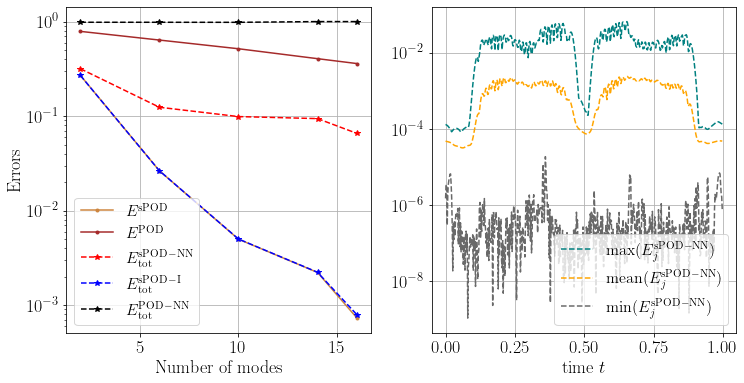

In [16]:
truncated_modes = np.array([2, 6, 10, 14, 16])
E_sPOD = np.array([0.26982, 0.02641, 0.00499, 0.00222, 0.00073])
E_POD = np.array([0.78781, 0.63762, 0.51599, 0.40523, 0.35954])
E_sPOD_NN = np.array([0.31729, 0.12410, 0.09889, 0.09411, 0.06559])
E_sPOD_I = np.array([0.26982, 0.02641, 0.00501, 0.00223, 0.00079])
E_POD_NN = np.array([0.9837, 0.9833, 0.9822, 1.0, 1.0])

err = errors[0]
err_min = [min(x) for x in err]
err_max = [max(x) for x in err]
err_mean = [mean(x) for x in err]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(truncated_modes, E_sPOD, color="peru", linestyle='-', marker=".", label=r"$E^{\mathrm{sPOD}}$")
axs[0].semilogy(truncated_modes, E_POD, color="brown", linestyle='-', marker=".", label=r"$E^{\mathrm{POD}}$")
axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}_{\mathrm{tot}}$")
axs[0].set_xlabel('Number of modes')
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].legend(loc='lower left')

axs[1].semilogy(df.t, err_max, color="teal", linestyle='--', label=r"max$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_mean, color="orange", linestyle='--', label=r"mean$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_min, color="dimgrey", linestyle='--', label=r"min$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".eps", format='eps',dpi=600, transparent=True)